## Table of Contents


1. Train a dummy neural network on a classification dataset and learn things like:  
   using dataloaders, learning rates, checkpointing the best model, training followed by inferencing, early stopping
2. Experiment with different hyperparameters that may increase/decrease the accuracy score:
    1. Effect of different batch sizes on model convergence 
    2. Effect of different learning rates on task loss/accuracy
    3. Effect of different activation functions on task loss/accuracy


## Train a dummy neural network on a classification dataset

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
from tqdm import tqdm, trange
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, Dataset
from transformers import (
    AdamW, get_linear_schedule_with_warmup
)
from sklearn.metrics import f1_score, precision_score, recall_score

In [ ]:
# loading the mnist dataset, train and test are datasets containing tensors
mnist_train = datasets.MNIST('data', train = True, download = True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('data', train = False, download = True, transform=transforms.ToTensor())

In [ ]:
print(mnist_train)
print(mnist_test)
print("Image tensor shape {}".format(list(mnist_train)[0][0].shape))
print(type(list(mnist_train)[0][0]))

Image tensor shape torch.Size([1, 28, 28])
<class 'torch.Tensor'>


Here, we select only a few samples for our training to have a lesser training time.
We use `torch.data.subset` to select a subset of the mnist data

In [ ]:
evens = list(range(0, len(mnist_train), 10))
odds = list(range(1, len(mnist_test), 10))

In [ ]:
mnist_train = torch.utils.data.Subset(mnist_train, evens)
mnist_test = torch.utils.data.Subset(mnist_test, odds)
print("Final train and test sizes are {}, {}".format(len(mnist_train), len(mnist_test)))

Final train and test sizes are 6000, 1000


In [ ]:
def set_seed(args):
    random.seed(args["seed"])
    np.random.seed(args["seed"])
    torch.manual_seed(args["seed"])
    torch.cuda.manual_seed_all(args["seed"])

In [ ]:
args = {"seed": 42}
device = torch.device("cpu")
args["device"] = device
print(args["device"])

set_seed(args)

cpu


In [ ]:
class Net(nn.Module):

    def __init__(self, args):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 80)
        self.fc2 = nn.Linear(80, 30)
        self.fc3 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = args["activation"](self.fc1(x))
        x = args["activation"](self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# training loop
def train(args, train_dataset, val_dataset, model):
    
    # Prepare train data
    train_sampler = RandomSampler(train_dataset)  # random sampling of training data
    
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args["train_batch_size"])
    train_batch_size = args["train_batch_size"]

    t_total = len(train_dataloader) * args["num_train_epochs"]
    optimizer = args["optimizer"](model.parameters(), lr=args["learning_rate"], eps=args["adam_epsilon"])
    
    # explain what is learning rate warmup
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=t_total // 10, num_training_steps=t_total)
    criterion = nn.CrossEntropyLoss()  # defining the loss function

    # Train!
    print("***** Running training *****")
    print("  Num examples = ", len(train_dataset))
    print("  Num Epochs = ", args["num_train_epochs"])
    print("  Instantaneous batch size per GPU = ", train_batch_size)

    global_step = 0
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    
    train_iterator = trange(int(args["num_train_epochs"]), desc="Epoch")
    
    best_f1_score = 0
    if not os.path.exists(args["output_dir"]):
        os.makedirs(args["output_dir"])
      
    patience = 3
    last_best_epoch = -1


    for epoch in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration")
        
        for step, batch in enumerate(epoch_iterator):
            model.train()

            batch = tuple(t.to(args["device"]) for t in batch)  # bringing the examples on same device as the model
            input_, labels_ = batch
            outputs = model(input_)

            loss = criterion(outputs, labels_)

            loss.backward()
            
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(
                model.parameters(), args["max_grad_norm"])

            tr_loss += loss.item()
            optimizer.step()
            scheduler.step()
            model.zero_grad()
            optimizer.zero_grad()
            global_step += 1

        print("Train loss: {}".format(tr_loss/global_step))
        train_losses.append(tr_loss/global_step)
        
        # get train accuracy
        print("Train accuracy stats: ")
        results = evaluate(args, train_dataset, model)
        print("Train accuracy: {}".format(results["acc"]))
        train_acc.append(results["acc"])

        # Recording validation f1 scores
        results = evaluate(args, val_dataset, model)
        print("Validation accuracy: {}".format(results["acc"]))
        print("Validation loss: {}".format(results["eval_loss"]))
        
        val_losses.append(results["eval_loss"])
        val_acc.append(results["acc"])
        
        if results.get('f1') > best_f1_score and args["save_steps"] > 0:
            best_f1_score = results.get('f1')
            model_to_save = model.module if hasattr(model, "module") else model
            torch.save(model_to_save.state_dict(), args["output_dir"] + "clssnn.pth")
            torch.save(args, os.path.join(args["output_dir"], "training_args.bin"))
            last_best_epoch = epoch
            print("Last best epoch is {}".format(last_best_epoch))
        elif epoch - last_best_epoch > patience:
            print("Early stopped at epoch {}".format(epoch))
            break
    
    return train_losses, train_acc, val_losses, val_acc

def evaluate(args, val_dataset, model):
    
    eval_sampler = SequentialSampler(val_dataset)
    eval_dataloader = DataLoader(
        val_dataset, sampler=eval_sampler, batch_size=args["eval_batch_size"])
    
    results = {}
    criterion = nn.CrossEntropyLoss()

    print("  Num examples = ", len(val_dataset))
    print("  Batch size = ", args["eval_batch_size"])
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(args["device"]) for t in batch)

        with torch.no_grad():
            inputs, labels_ = batch

            outputs = model(inputs)  # forward pass
            logits = outputs

            loss = criterion(outputs, labels_)
            eval_loss += loss.mean().item()

        nb_eval_steps += 1

        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels_.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels_.detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    preds = np.argmax(preds, axis=1)
    result = acc_and_f1(preds, out_label_ids)
    results.update(result)
    results["eval_loss"] = eval_loss

    return results


def simple_accuracy(preds, labels):
    return (preds == labels).mean()

def acc_and_f1(preds, labels):
    acc = simple_accuracy(preds, labels)
    f1 = f1_score(y_true=labels, y_pred=preds, average='weighted')
    precision = precision_score(
        y_true=labels, y_pred=preds, average='weighted')
    recall = recall_score(y_true=labels, y_pred=preds, average='weighted')
    
    return{
        "acc": acc,
        "f1": f1,
        "acc_and_f1": (acc + f1) / 2,
        "precision": precision,
        "recall": recall
    }

In [ ]:
# defining training hyperparameters

args["train_batch_size"] = 60
args["eval_batch_size"] = 32
args["num_train_epochs"] = 5
args["optimizer"] = AdamW
args["learning_rate"] = 1.5e-3
args["adam_epsilon"] = 1e-8
args["output_dir"] = "./output/"
args["max_grad_norm"] = 1.0
args["save_steps"] = 1
args["activation"] = F.relu

model = Net(args)
model.to(args["device"])

Net(
  (fc1): Linear(in_features=784, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=10, bias=True)
)

In [ ]:
train_losses, train_acc, val_losses, val_acc = train(args, mnist_train, mnist_test, model)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


***** Running training *****
  Num examples =  6000
  Num Epochs =  5
  Instantaneous batch size per GPU =  60


Iteration: 100%|██████████| 100/100 [00:01<00:00, 58.42it/s]


Train loss: 1.422744137942791
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 129.09it/s]


Train accuracy: 0.8486666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  20%|██        | 1/5 [00:03<00:13,  3.48s/it]

Validation accuracy: 0.84
Validation loss: 0.5355983781628311
Last best epoch is 0



Iteration: 100%|██████████| 100/100 [00:04<00:00, 24.65it/s]


Train loss: 0.9317216406017542
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 108.31it/s]


Train accuracy: 0.8998333333333334
  Num examples =  1000
  Batch size =  32



Epoch:  40%|████      | 2/5 [00:09<00:15,  5.04s/it]

Validation accuracy: 0.886
Validation loss: 0.40028800442814827
Last best epoch is 1



Iteration: 100%|██████████| 100/100 [00:01<00:00, 62.79it/s]


Train loss: 0.7352684825658798
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 126.73it/s]


Train accuracy: 0.9165
  Num examples =  1000
  Batch size =  32



Epoch:  60%|██████    | 3/5 [00:13<00:08,  4.29s/it]

Validation accuracy: 0.897
Validation loss: 0.3643164561362937
Last best epoch is 2



Iteration: 100%|██████████| 100/100 [00:01<00:00, 61.89it/s]


Train loss: 0.6261395658366382
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 124.95it/s]


Train accuracy: 0.9253333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  80%|████████  | 4/5 [00:16<00:03,  3.95s/it]

Validation accuracy: 0.906
Validation loss: 0.35447605076478794
Last best epoch is 3



Iteration: 100%|██████████| 100/100 [00:01<00:00, 62.36it/s]


Train loss: 0.5556174245476723
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 96.14it/s]


Train accuracy: 0.9263333333333333
  Num examples =  1000
  Batch size =  32



Epoch: 100%|██████████| 5/5 [00:20<00:00,  4.10s/it]

Validation accuracy: 0.904
Validation loss: 0.3424428665312007


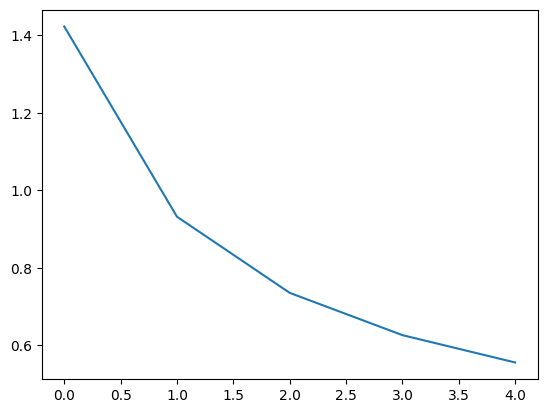

In [ ]:
plt.plot(train_losses)
plt.show()

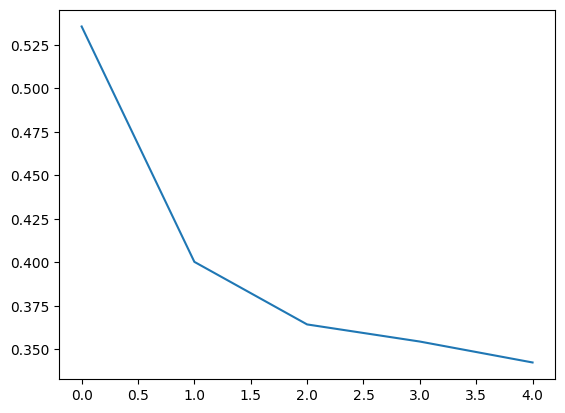

In [ ]:
plt.plot(val_losses)
plt.show()

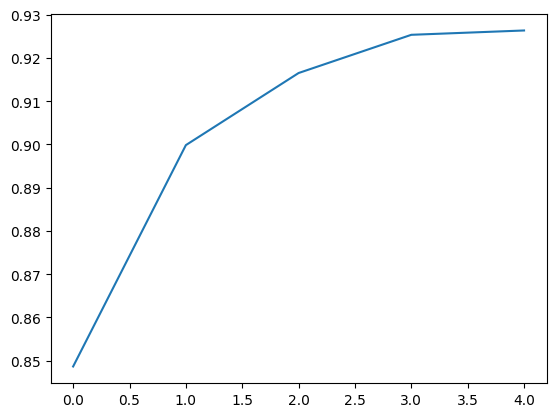

In [ ]:
plt.plot(train_acc)
plt.show()

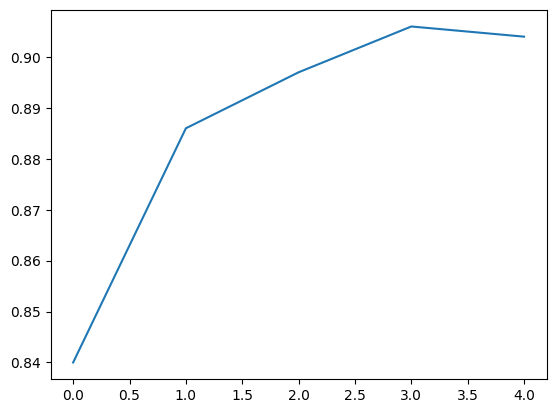

In [ ]:
plt.plot(val_acc)
plt.show()

In [ ]:
# Inference
def inference(model, sample):
    softmax = nn.Softmax(dim=-1)
    
    model.eval()

    with torch.no_grad():
        inputs, labels_ = sample

        logits = model(inputs)  # forward pass
        outputs = softmax(logits)
    print("Preds are {}".format(outputs))
    preds = outputs.detach().cpu().numpy()[0]
    logits = logits.detach().cpu().numpy()[0]
    print("Outputs are {}".format(preds))
    print("Logits are {}".format(logits))
    print("Predicted number is {}".format(np.argmax(preds)))
    print("Actual number is {}".format(labels_))
    

# load model
model = Net(args)
model.load_state_dict(torch.load("./output/clssnn.pth"))
model.to(args["device"])

sample = mnist_test[10]
inference(model, sample)

Preds are tensor([[9.7663e-01, 1.0861e-07, 2.6373e-05, 4.5426e-06, 2.8373e-06, 2.0598e-02,
         3.2505e-05, 5.4727e-06, 2.5150e-03, 1.8751e-04]])
Outputs are [9.7662747e-01 1.0860608e-07 2.6373276e-05 4.5426377e-06 2.8372931e-06
 2.0598153e-02 3.2505366e-05 5.4726625e-06 2.5150010e-03 1.8751110e-04]
Logits are [ 7.929114  -8.082774  -2.5903955 -4.3492393 -4.8198967  4.07021
 -2.3813417 -4.1629815  1.9672818 -0.6289083]
Predicted number is 0
Actual number is 0


## Experiment with different Training Batch Sizes 

In [ ]:
from collections import defaultdict

In [ ]:

batch_sizes = [20,40,60,80]
train_loss_df = defaultdict()
train_acc_df = defaultdict()
val_loss_df = defaultdict()
val_acc_df = defaultdict()

for bs in batch_sizes:
    args["train_batch_size"] = bs
    model = Net(args)
    model.to(args["device"])
    train_losses, train_acc, val_losses, val_acc = train(args, mnist_train, mnist_test, model)
    train_loss_df[bs] = train_losses
    train_acc_df[bs] = train_acc 
    val_loss_df[bs] = val_losses
    val_acc_df[bs] =  val_acc

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


***** Running training *****
  Num examples =  6000
  Num Epochs =  10
  Instantaneous batch size per GPU =  20


Iteration: 100%|██████████| 300/300 [00:01<00:00, 165.20it/s]


Train loss: 1.3350132169326145
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 158.24it/s]


Train accuracy: 0.8521666666666666
  Num examples =  1000
  Batch size =  32



Epoch:  10%|█         | 1/10 [00:03<00:29,  3.28s/it]

Validation accuracy: 0.813
Validation loss: 0.5980501589365304
Last best epoch is 0



Iteration: 100%|██████████| 300/300 [00:01<00:00, 166.69it/s]


Train loss: 0.880592090835174
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 159.83it/s]


Train accuracy: 0.9213333333333333
  Num examples =  1000
  Batch size =  32



Evaluating: 100%|██████████| 32/32 [00:00<00:00, 176.85it/s]

Validation accuracy: 0.897


Epoch:  20%|██        | 2/10 [00:06<00:26,  3.25s/it]


Validation loss: 0.36819742171792313
Last best epoch is 1



Iteration: 100%|██████████| 300/300 [00:02<00:00, 122.19it/s]


Train loss: 0.6886253025672502
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 93.66it/s]


Train accuracy: 0.9328333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  30%|███       | 3/10 [00:11<00:28,  4.03s/it]

Validation accuracy: 0.906
Validation loss: 0.356871351483278
Last best epoch is 2



Iteration: 100%|██████████| 300/300 [00:04<00:00, 65.70it/s]


Train loss: 0.5759365404948281
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 73.16it/s]


Train accuracy: 0.946
  Num examples =  1000
  Batch size =  32



Epoch:  40%|████      | 4/10 [00:18<00:32,  5.36s/it]

Validation accuracy: 0.907
Validation loss: 0.31004278716864064
Last best epoch is 3



Iteration: 100%|██████████| 300/300 [00:01<00:00, 164.05it/s]


Train loss: 0.4997824913021177
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 123.50it/s]


Train accuracy: 0.9605
  Num examples =  1000
  Batch size =  32



Epoch:  50%|█████     | 5/10 [00:22<00:23,  4.76s/it]

Validation accuracy: 0.92
Validation loss: 0.29291455513157416
Last best epoch is 4



Iteration: 100%|██████████| 300/300 [00:02<00:00, 105.16it/s]


Train loss: 0.4432606263885585
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 156.28it/s]


Train accuracy: 0.9618333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  60%|██████    | 6/10 [00:26<00:18,  4.62s/it]

Validation accuracy: 0.919
Validation loss: 0.31583544073509984



Iteration: 100%|██████████| 300/300 [00:01<00:00, 168.23it/s]


Train loss: 0.3986078306624577
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 110.20it/s]


Train accuracy: 0.973
  Num examples =  1000
  Batch size =  32



Epoch:  70%|███████   | 7/10 [00:30<00:13,  4.34s/it]

Validation accuracy: 0.92
Validation loss: 0.2801409380917903
Last best epoch is 6



Iteration: 100%|██████████| 300/300 [00:02<00:00, 126.05it/s]


Train loss: 0.3624046810695048
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 95.02it/s] 


Train accuracy: 0.9751666666666666
  Num examples =  1000
  Batch size =  32



Epoch:  80%|████████  | 8/10 [00:35<00:09,  4.51s/it]

Validation accuracy: 0.918
Validation loss: 0.29246145029901527



Iteration: 100%|██████████| 300/300 [00:07<00:00, 42.26it/s]


Train loss: 0.3325711275290491
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 63.63it/s] 


Train accuracy: 0.9803333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  90%|█████████ | 9/10 [00:45<00:06,  6.34s/it]

Validation accuracy: 0.923
Validation loss: 0.27325279933575075
Last best epoch is 8



Iteration: 100%|██████████| 300/300 [00:02<00:00, 135.48it/s]


Train loss: 0.30756589594304873
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 135.28it/s]


Train accuracy: 0.9803333333333333
  Num examples =  1000
  Batch size =  32



Epoch: 100%|██████████| 10/10 [00:50<00:00,  5.00s/it]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation accuracy: 0.924
Validation loss: 0.2747858540242305
Last best epoch is 9
***** Running training *****
  Num examples =  6000
  Num Epochs =  10
  Instantaneous batch size per GPU =  40


Iteration: 100%|██████████| 150/150 [00:03<00:00, 45.38it/s]


Train loss: 1.53218374868234
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:05<00:00, 34.97it/s]


Train accuracy: 0.8511666666666666
  Num examples =  1000
  Batch size =  32



Epoch:  10%|█         | 1/10 [00:09<01:21,  9.01s/it]

Validation accuracy: 0.845
Validation loss: 0.5272386721335351
Last best epoch is 0



Iteration: 100%|██████████| 150/150 [00:01<00:00, 86.46it/s]


Train loss: 0.9818090257048607
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 140.22it/s]


Train accuracy: 0.9096666666666666
  Num examples =  1000
  Batch size =  32



Epoch:  20%|██        | 2/10 [00:12<00:45,  5.70s/it]

Validation accuracy: 0.88
Validation loss: 0.40199869219213724
Last best epoch is 1



Iteration: 100%|██████████| 150/150 [00:01<00:00, 88.52it/s]


Train loss: 0.7590173635880152
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 141.36it/s]


Train accuracy: 0.9285
  Num examples =  1000
  Batch size =  32



Epoch:  30%|███       | 3/10 [00:15<00:32,  4.62s/it]

Validation accuracy: 0.912
Validation loss: 0.33430776221212
Last best epoch is 2



Iteration: 100%|██████████| 150/150 [00:02<00:00, 70.17it/s]


Train loss: 0.6332743909706672
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 84.88it/s]


Train accuracy: 0.9465
  Num examples =  1000
  Batch size =  32



Epoch:  40%|████      | 4/10 [00:20<00:28,  4.69s/it]

Validation accuracy: 0.909
Validation loss: 0.3151872422895394



Iteration: 100%|██████████| 150/150 [00:01<00:00, 78.65it/s]


Train loss: 0.5484270879427592
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 135.02it/s]


Train accuracy: 0.9508333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  50%|█████     | 5/10 [00:24<00:21,  4.31s/it]

Validation accuracy: 0.907
Validation loss: 0.3098856525029987



Iteration: 100%|██████████| 150/150 [00:01<00:00, 84.85it/s]


Train loss: 0.48666458427285153
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 140.45it/s]


Train accuracy: 0.9565
  Num examples =  1000
  Batch size =  32



Epoch:  60%|██████    | 6/10 [00:27<00:16,  4.01s/it]

Validation accuracy: 0.913
Validation loss: 0.32186927512520924
Last best epoch is 5



Iteration: 100%|██████████| 150/150 [00:01<00:00, 86.36it/s]


Train loss: 0.43914038038324743
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 149.94it/s]


Train accuracy: 0.9653333333333334
  Num examples =  1000
  Batch size =  32



Epoch:  70%|███████   | 7/10 [00:30<00:11,  3.78s/it]

Validation accuracy: 0.913
Validation loss: 0.3126678703702055



Iteration: 100%|██████████| 150/150 [00:05<00:00, 28.10it/s]


Train loss: 0.4010716249545415
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 131.15it/s]


Train accuracy: 0.9706666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  80%|████████  | 8/10 [00:38<00:09,  4.84s/it]

Validation accuracy: 0.916
Validation loss: 0.2871933712158352
Last best epoch is 7



Iteration: 100%|██████████| 150/150 [00:02<00:00, 58.39it/s]


Train loss: 0.36984789009378466
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 85.74it/s] 


Train accuracy: 0.9738333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  90%|█████████ | 9/10 [00:43<00:04,  4.92s/it]

Validation accuracy: 0.916
Validation loss: 0.28554360195994377



Iteration: 100%|██████████| 150/150 [00:01<00:00, 87.23it/s]


Train loss: 0.3438991057431946
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 138.22it/s]


Train accuracy: 0.9761666666666666
  Num examples =  1000
  Batch size =  32



Epoch: 100%|██████████| 10/10 [00:46<00:00,  4.67s/it]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation accuracy: 0.918
Validation loss: 0.28550655403523706
Last best epoch is 9
***** Running training *****
  Num examples =  6000
  Num Epochs =  10
  Instantaneous batch size per GPU =  60


Iteration: 100%|██████████| 100/100 [00:03<00:00, 26.21it/s]


Train loss: 1.7034702372550965
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:03<00:00, 48.20it/s]


Train accuracy: 0.8005
  Num examples =  1000
  Batch size =  32



Epoch:  10%|█         | 1/10 [00:08<01:12,  8.04s/it]

Validation accuracy: 0.8
Validation loss: 0.6862953477539122
Last best epoch is 0



Iteration: 100%|██████████| 100/100 [00:01<00:00, 65.41it/s]


Train loss: 1.091253869459033
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 138.32it/s]


Train accuracy: 0.895
  Num examples =  1000
  Batch size =  32



Epoch:  20%|██        | 2/10 [00:11<00:41,  5.21s/it]

Validation accuracy: 0.866
Validation loss: 0.45418242644518614
Last best epoch is 1



Iteration: 100%|██████████| 100/100 [00:01<00:00, 63.48it/s]


Train loss: 0.8437161468962828
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 130.32it/s]


Train accuracy: 0.9166666666666666
  Num examples =  1000
  Batch size =  32



Epoch:  30%|███       | 3/10 [00:14<00:30,  4.36s/it]

Validation accuracy: 0.894
Validation loss: 0.37630965327844024
Last best epoch is 2



Iteration: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Train loss: 0.7062467379681766
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 67.08it/s]


Train accuracy: 0.9286666666666666
  Num examples =  1000
  Batch size =  32



Epoch:  40%|████      | 4/10 [00:21<00:32,  5.49s/it]

Validation accuracy: 0.901
Validation loss: 0.3484412202378735
Last best epoch is 3



Iteration: 100%|██████████| 100/100 [00:02<00:00, 49.79it/s]


Train loss: 0.6161876980513334
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 134.56it/s]


Train accuracy: 0.9326666666666666
  Num examples =  1000
  Batch size =  32



Epoch:  50%|█████     | 5/10 [00:25<00:24,  4.86s/it]

Validation accuracy: 0.898
Validation loss: 0.34133937512524426



Iteration: 100%|██████████| 100/100 [00:01<00:00, 62.45it/s]


Train loss: 0.5511755021537343
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 133.87it/s]


Train accuracy: 0.9455
  Num examples =  1000
  Batch size =  32



Epoch:  60%|██████    | 6/10 [00:28<00:17,  4.35s/it]

Validation accuracy: 0.909
Validation loss: 0.32653159662731923
Last best epoch is 5



Iteration: 100%|██████████| 100/100 [00:01<00:00, 59.09it/s]


Train loss: 0.5012203222353544
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 92.47it/s]


Train accuracy: 0.9496666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  70%|███████   | 7/10 [00:33<00:12,  4.29s/it]

Validation accuracy: 0.915
Validation loss: 0.31161926707136445
Last best epoch is 6



Iteration: 100%|██████████| 100/100 [00:02<00:00, 37.67it/s]


Train loss: 0.4617802268033847
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 105.62it/s]


Train accuracy: 0.9556666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  80%|████████  | 8/10 [00:37<00:08,  4.44s/it]

Validation accuracy: 0.915
Validation loss: 0.3054942355956882
Last best epoch is 7



Iteration: 100%|██████████| 100/100 [00:01<00:00, 61.31it/s]


Train loss: 0.42942124853117597
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 124.52it/s]


Train accuracy: 0.9563333333333334
  Num examples =  1000
  Batch size =  32



Epoch:  90%|█████████ | 9/10 [00:41<00:04,  4.14s/it]

Validation accuracy: 0.917
Validation loss: 0.3077572748006787
Last best epoch is 8



Iteration: 100%|██████████| 100/100 [00:01<00:00, 61.29it/s]


Train loss: 0.40256730232387783
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 133.01it/s]


Train accuracy: 0.9588333333333333
  Num examples =  1000
  Batch size =  32



Epoch: 100%|██████████| 10/10 [00:44<00:00,  4.47s/it]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation accuracy: 0.912
Validation loss: 0.3038713170099072
***** Running training *****
  Num examples =  6000
  Num Epochs =  10
  Instantaneous batch size per GPU =  80


Iteration: 100%|██████████| 75/75 [00:01<00:00, 46.20it/s]


Train loss: 1.8239322598775227
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 86.07it/s]


Train accuracy: 0.7936666666666666
  Num examples =  1000
  Batch size =  32



Epoch:  10%|█         | 1/10 [00:04<00:38,  4.28s/it]

Validation accuracy: 0.803
Validation loss: 0.7694049254059792
Last best epoch is 0



Iteration: 100%|██████████| 75/75 [00:02<00:00, 31.92it/s]


Train loss: 1.1805434629321099
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 113.47it/s]


Train accuracy: 0.8891666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  20%|██        | 2/10 [00:08<00:34,  4.31s/it]

Validation accuracy: 0.87
Validation loss: 0.4531976864673197
Last best epoch is 1



Iteration: 100%|██████████| 75/75 [00:01<00:00, 48.55it/s]


Train loss: 0.9155674594640731
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 127.69it/s]


Train accuracy: 0.9081666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  30%|███       | 3/10 [00:11<00:27,  3.87s/it]

Validation accuracy: 0.89
Validation loss: 0.3938684717286378
Last best epoch is 2



Iteration: 100%|██████████| 75/75 [00:01<00:00, 47.17it/s]


Train loss: 0.7674059416850408
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 131.03it/s]


Train accuracy: 0.9161666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  40%|████      | 4/10 [00:15<00:22,  3.67s/it]

Validation accuracy: 0.895
Validation loss: 0.3761092201457359
Last best epoch is 3



Iteration: 100%|██████████| 75/75 [00:01<00:00, 44.38it/s]


Train loss: 0.6709317087332408
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 85.64it/s]


Train accuracy: 0.9238333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  50%|█████     | 5/10 [00:19<00:19,  3.91s/it]

Validation accuracy: 0.895
Validation loss: 0.3574903780827299



Iteration: 100%|██████████| 75/75 [00:02<00:00, 29.90it/s]


Train loss: 0.6023025063011381
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 91.91it/s] 


Train accuracy: 0.9363333333333334
  Num examples =  1000
  Batch size =  32



Epoch:  60%|██████    | 6/10 [00:24<00:16,  4.24s/it]

Validation accuracy: 0.898
Validation loss: 0.3531599552370608
Last best epoch is 5



Iteration: 100%|██████████| 75/75 [00:01<00:00, 43.77it/s]


Train loss: 0.5501741546108609
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 122.29it/s]


Train accuracy: 0.9401666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  70%|███████   | 7/10 [00:28<00:12,  4.03s/it]

Validation accuracy: 0.908
Validation loss: 0.33375831693410873
Last best epoch is 6



Iteration: 100%|██████████| 75/75 [00:01<00:00, 46.63it/s]


Train loss: 0.5091719067717592
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 118.73it/s]


Train accuracy: 0.9398333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  80%|████████  | 8/10 [00:31<00:07,  3.87s/it]

Validation accuracy: 0.903
Validation loss: 0.33748099429067224



Iteration: 100%|██████████| 75/75 [00:01<00:00, 45.53it/s]


Train loss: 0.47576629718144736
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 88.54it/s]


Train accuracy: 0.943
  Num examples =  1000
  Batch size =  32



Epoch:  90%|█████████ | 9/10 [00:35<00:03,  3.98s/it]

Validation accuracy: 0.909
Validation loss: 0.32923110853880644
Last best epoch is 8



Iteration: 100%|██████████| 75/75 [00:02<00:00, 28.76it/s]


Train loss: 0.44822394620378814
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 110.55it/s]


Train accuracy: 0.9461666666666667
  Num examples =  1000
  Batch size =  32



Epoch: 100%|██████████| 10/10 [00:40<00:00,  4.05s/it]

Validation accuracy: 0.912
Validation loss: 0.3274535068194382
Last best epoch is 9


In [ ]:
train_loss_df[20]

[1.3350132169326145,
 0.880592090835174,
 0.6886253025672502,
 0.5759365404948281,
 0.4997824913021177,
 0.4432606263885585,
 0.3986078306624577,
 0.3624046810695048,
 0.3325711275290491,
 0.30756589594304873]

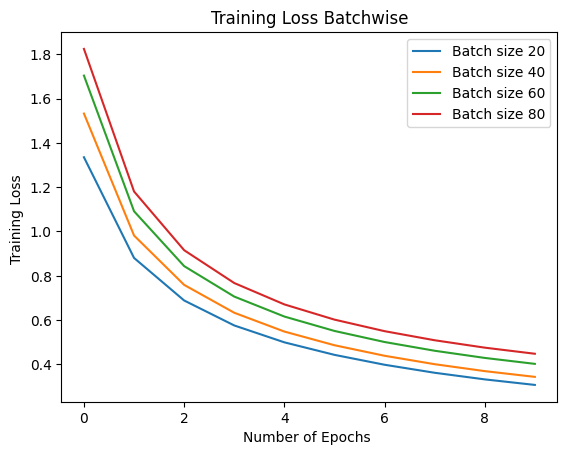

In [ ]:

plt.ylabel("Training Loss ")
plt.xlabel("Number of Epochs ")
plt.plot(train_loss_df[20], label = "Batch size 20")
plt.plot(train_loss_df[40], label = "Batch size 40")
plt.plot(train_loss_df[60], label = "Batch size 60")
plt.plot(train_loss_df[80], label = "Batch size 80")
plt.legend()

plt.title("Training Loss Batchwise")
plt.show()

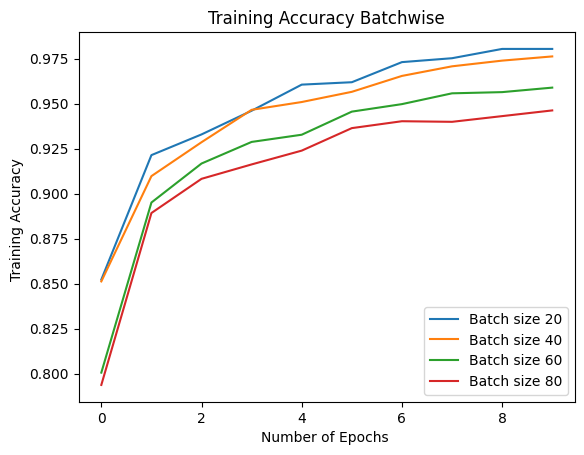

In [ ]:

plt.ylabel("Training Accuracy ")
plt.xlabel("Number of Epochs ")
plt.plot(train_acc_df[20], label = "Batch size 20")
plt.plot(train_acc_df[40], label = "Batch size 40")
plt.plot(train_acc_df[60], label = "Batch size 60")
plt.plot(train_acc_df[80], label = "Batch size 80")
plt.legend()
plt.title("Training Accuracy Batchwise")

plt.show()

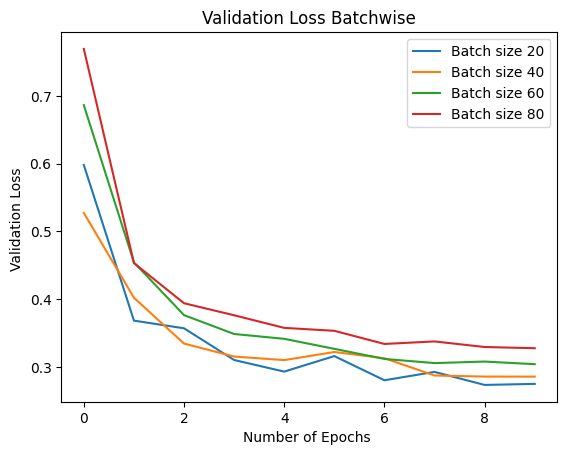

In [ ]:

plt.ylabel("Validation Loss ")
plt.xlabel("Number of Epochs ")
plt.plot(val_loss_df[20], label = "Batch size 20")
plt.plot(val_loss_df[40], label = "Batch size 40")
plt.plot(val_loss_df[60], label = "Batch size 60")
plt.plot(val_loss_df[80], label = "Batch size 80")
plt.legend()

plt.title("Validation Loss Batchwise")

plt.show()

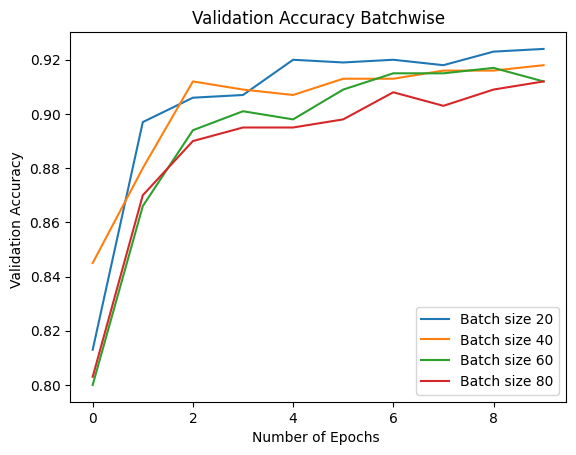

In [ ]:

plt.ylabel("Validation Accuracy ")
plt.xlabel("Number of Epochs ")

plt.plot(val_acc_df[20], label = "Batch size 20")
plt.plot(val_acc_df[40], label = "Batch size 40")
plt.plot(val_acc_df[60], label = "Batch size 60")
plt.plot(val_acc_df[80], label = "Batch size 80")
plt.legend()
plt.title("Validation Accuracy Batchwise")

plt.show()



As we can see, smaller batch size aids faster convergence and better generalization to unseen data. For more in-depth information refer to: https://medium.com/geekculture/why-small-batch-sizes-lead-to-greater-generalization-in-deep-learning-a00a32251a4f

## Experiment with different Learning Rates

In [ ]:


learning_rates = [1.5e-3,1.2e-2,1.1e-1]
train_loss_df = defaultdict()
train_acc_df = defaultdict()
val_loss_df = defaultdict()
val_acc_df = defaultdict()

for bs in learning_rates:
    args["learning_rate"] = bs
    model = Net(args)
    model.to(args["device"])
    train_losses, train_acc, val_losses, val_acc = train(args, mnist_train, mnist_test, model)
    train_loss_df[bs] = train_losses
    train_acc_df[bs] = train_acc 
    val_loss_df[bs] = val_losses
    val_acc_df[bs] =  val_acc


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


***** Running training *****
  Num examples =  6000
  Num Epochs =  10
  Instantaneous batch size per GPU =  80


Iteration: 100%|██████████| 75/75 [00:06<00:00, 11.37it/s]


Train loss: 1.8502251720428466
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:12<00:00, 15.57it/s]


Train accuracy: 0.7496666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  10%|█         | 1/10 [00:20<03:02, 20.31s/it]

Validation accuracy: 0.76
Validation loss: 0.8374381810426712
Last best epoch is 0



Iteration: 100%|██████████| 75/75 [00:07<00:00,  9.78it/s]


Train loss: 1.2040925860404967
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:05<00:00, 36.16it/s]


Train accuracy: 0.8856666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  20%|██        | 2/10 [00:33<02:10, 16.36s/it]

Validation accuracy: 0.87
Validation loss: 0.43457958148792386
Last best epoch is 1



Iteration: 100%|██████████| 75/75 [00:02<00:00, 25.86it/s]


Train loss: 0.9279263934161928
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 138.58it/s]


Train accuracy: 0.9126666666666666
  Num examples =  1000
  Batch size =  32



Epoch:  30%|███       | 3/10 [00:38<01:16, 10.98s/it]

Validation accuracy: 0.886
Validation loss: 0.3925605969270691
Last best epoch is 2



Iteration: 100%|██████████| 75/75 [00:01<00:00, 40.19it/s]


Train loss: 0.7738834450642268
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 135.96it/s]


Train accuracy: 0.9263333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  40%|████      | 4/10 [00:42<00:48,  8.11s/it]

Validation accuracy: 0.899
Validation loss: 0.35148824186762795
Last best epoch is 3



Iteration: 100%|██████████| 75/75 [00:04<00:00, 15.92it/s]


Train loss: 0.6730960854291916
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:03<00:00, 60.97it/s]


Train accuracy: 0.9313333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  50%|█████     | 5/10 [00:50<00:41,  8.22s/it]

Validation accuracy: 0.898
Validation loss: 0.33869101596064866



Iteration: 100%|██████████| 75/75 [00:03<00:00, 23.20it/s]


Train loss: 0.6006906867192852
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 68.89it/s] 


Train accuracy: 0.9428333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  60%|██████    | 6/10 [00:56<00:30,  7.56s/it]

Validation accuracy: 0.904
Validation loss: 0.3177389089250937
Last best epoch is 5



Iteration: 100%|██████████| 75/75 [00:01<00:00, 39.88it/s]


Train loss: 0.5455439006572678
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 86.86it/s]


Train accuracy: 0.945
  Num examples =  1000
  Batch size =  32



Epoch:  70%|███████   | 7/10 [01:01<00:19,  6.58s/it]

Validation accuracy: 0.906
Validation loss: 0.31998112017754465
Last best epoch is 6



Iteration: 100%|██████████| 75/75 [00:01<00:00, 44.50it/s]


Train loss: 0.5017708499108752
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 138.81it/s]


Train accuracy: 0.951
  Num examples =  1000
  Batch size =  32



Epoch:  80%|████████  | 8/10 [01:04<00:11,  5.55s/it]

Validation accuracy: 0.906
Validation loss: 0.3051320184604265
Last best epoch is 7



Iteration: 100%|██████████| 75/75 [00:01<00:00, 51.97it/s]


Train loss: 0.46626082801156576
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 141.60it/s]


Train accuracy: 0.9528333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  90%|█████████ | 9/10 [01:07<00:04,  4.78s/it]

Validation accuracy: 0.908
Validation loss: 0.2990200593776535
Last best epoch is 8



Iteration: 100%|██████████| 75/75 [00:01<00:00, 52.03it/s]


Train loss: 0.43701998341083526
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 133.81it/s]


Train accuracy: 0.9545
  Num examples =  1000
  Batch size =  32



Epoch: 100%|██████████| 10/10 [01:11<00:00,  7.11s/it]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation accuracy: 0.907
Validation loss: 0.2950705281109549
***** Running training *****
  Num examples =  6000
  Num Epochs =  10
  Instantaneous batch size per GPU =  80


Iteration: 100%|██████████| 75/75 [00:01<00:00, 41.90it/s]


Train loss: 1.1226038904984792
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 96.42it/s]


Train accuracy: 0.8675
  Num examples =  1000
  Batch size =  32



Epoch:  10%|█         | 1/10 [00:04<00:38,  4.23s/it]

Validation accuracy: 0.855
Validation loss: 0.4868951844982803
Last best epoch is 0



Iteration: 100%|██████████| 75/75 [00:02<00:00, 34.22it/s]


Train loss: 0.7469629807273547
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 137.89it/s]


Train accuracy: 0.9195
  Num examples =  1000
  Batch size =  32



Epoch:  20%|██        | 2/10 [00:08<00:32,  4.02s/it]

Validation accuracy: 0.888
Validation loss: 0.3735284128924832
Last best epoch is 1



Iteration: 100%|██████████| 75/75 [00:01<00:00, 51.88it/s]


Train loss: 0.5801740966902839
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 132.53it/s]


Train accuracy: 0.9605
  Num examples =  1000
  Batch size =  32



Epoch:  30%|███       | 3/10 [00:11<00:25,  3.64s/it]

Validation accuracy: 0.925
Validation loss: 0.261432595027145
Last best epoch is 2



Iteration: 100%|██████████| 75/75 [00:01<00:00, 51.33it/s]


Train loss: 0.4723336759582162
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 137.20it/s]


Train accuracy: 0.9686666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  40%|████      | 4/10 [00:14<00:20,  3.45s/it]

Validation accuracy: 0.932
Validation loss: 0.28272709652082995
Last best epoch is 3



Iteration: 100%|██████████| 75/75 [00:01<00:00, 47.70it/s]


Train loss: 0.3958164470841487
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 92.08it/s]


Train accuracy: 0.9838333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  50%|█████     | 5/10 [00:18<00:18,  3.65s/it]

Validation accuracy: 0.929
Validation loss: 0.27117921510944143



Iteration: 100%|██████████| 75/75 [00:02<00:00, 30.52it/s]


Train loss: 0.3396317675088843
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 104.42it/s]


Train accuracy: 0.9916666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  60%|██████    | 6/10 [00:23<00:16,  4.06s/it]

Validation accuracy: 0.926
Validation loss: 0.25848886234962265



Iteration: 100%|██████████| 75/75 [00:02<00:00, 27.83it/s]


Train loss: 0.29531798670157083
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 74.19it/s]


Train accuracy: 0.997
  Num examples =  1000
  Batch size =  32



Epoch:  70%|███████   | 7/10 [00:29<00:14,  4.74s/it]

Validation accuracy: 0.935
Validation loss: 0.27367420551854593
Last best epoch is 6



Iteration: 100%|██████████| 75/75 [00:02<00:00, 32.92it/s]


Train loss: 0.26035892025140733
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:04<00:00, 46.84it/s]


Train accuracy: 0.9988333333333334
  Num examples =  1000
  Batch size =  32



Epoch:  80%|████████  | 8/10 [00:36<00:11,  5.53s/it]

Validation accuracy: 0.933
Validation loss: 0.28346507193055004



Iteration: 100%|██████████| 75/75 [00:02<00:00, 28.62it/s]


Train loss: 0.23246063653862586
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 127.95it/s]


Train accuracy: 0.9991666666666666
  Num examples =  1000
  Batch size =  32



Epoch:  90%|█████████ | 9/10 [00:41<00:05,  5.18s/it]

Validation accuracy: 0.933
Validation loss: 0.2854177208064357



Iteration: 100%|██████████| 75/75 [00:01<00:00, 51.09it/s]


Train loss: 0.2098892096908142
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 121.66it/s]


Train accuracy: 0.9995
  Num examples =  1000
  Batch size =  32



Epoch: 100%|██████████| 10/10 [00:44<00:00,  4.44s/it]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation accuracy: 0.931
Validation loss: 0.2899350253101147
***** Running training *****
  Num examples =  6000
  Num Epochs =  10
  Instantaneous batch size per GPU =  80


Iteration: 100%|██████████| 75/75 [00:01<00:00, 47.01it/s]


Train loss: 1.0991210412979127
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 125.35it/s]


Train accuracy: 0.7553333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  10%|█         | 1/10 [00:03<00:31,  3.50s/it]

Validation accuracy: 0.737
Validation loss: 0.9536013286560774
Last best epoch is 0



Iteration: 100%|██████████| 75/75 [00:02<00:00, 34.80it/s]


Train loss: 1.129363667567571
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 81.88it/s]


Train accuracy: 0.6611666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  20%|██        | 2/10 [00:08<00:34,  4.37s/it]

Validation accuracy: 0.626
Validation loss: 1.3490927182137966



Iteration: 100%|██████████| 75/75 [00:01<00:00, 40.01it/s]


Train loss: 1.1315492171711392
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 88.04it/s] 


Train accuracy: 0.7715
  Num examples =  1000
  Batch size =  32



Epoch:  30%|███       | 3/10 [00:12<00:30,  4.38s/it]

Validation accuracy: 0.77
Validation loss: 1.024531987030059
Last best epoch is 2



Iteration: 100%|██████████| 75/75 [00:01<00:00, 48.86it/s]


Train loss: 1.0676754864056905
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 134.17it/s]


Train accuracy: 0.7981666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  40%|████      | 4/10 [00:16<00:23,  3.95s/it]

Validation accuracy: 0.796
Validation loss: 1.0678071272559464
Last best epoch is 3



Iteration: 100%|██████████| 75/75 [00:01<00:00, 48.85it/s]


Train loss: 1.006622101386388
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:06<00:00, 29.47it/s]


Train accuracy: 0.8116666666666666
  Num examples =  1000
  Batch size =  32



Epoch:  50%|█████     | 5/10 [00:25<00:29,  5.85s/it]

Validation accuracy: 0.78
Validation loss: 0.8764429166913033



Iteration: 100%|██████████| 75/75 [00:03<00:00, 22.82it/s]


Train loss: 0.9258990412950516
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 72.08it/s]


Train accuracy: 0.8971666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  60%|██████    | 6/10 [00:31<00:24,  6.06s/it]

Validation accuracy: 0.864
Validation loss: 0.7756523401476443
Last best epoch is 5



Iteration: 100%|██████████| 75/75 [00:02<00:00, 31.17it/s]


Train loss: 0.8515948414234888
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:04<00:00, 44.95it/s]


Train accuracy: 0.8978333333333334
  Num examples =  1000
  Batch size =  32



Epoch:  70%|███████   | 7/10 [00:39<00:19,  6.43s/it]

Validation accuracy: 0.836
Validation loss: 0.7095539243891835



Iteration: 100%|██████████| 75/75 [00:03<00:00, 19.97it/s]


Train loss: 0.7865118070070942
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 74.77it/s]


Train accuracy: 0.913
  Num examples =  1000
  Batch size =  32



Epoch:  80%|████████  | 8/10 [00:45<00:13,  6.54s/it]

Validation accuracy: 0.861
Validation loss: 0.6119334883987904



Iteration: 100%|██████████| 75/75 [00:02<00:00, 34.46it/s]


Train loss: 0.72831346384905
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 70.46it/s]


Train accuracy: 0.9331666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  90%|█████████ | 9/10 [00:51<00:06,  6.14s/it]

Validation accuracy: 0.874
Validation loss: 0.6240959971910343
Last best epoch is 8



Iteration: 100%|██████████| 75/75 [00:02<00:00, 27.91it/s]


Train loss: 0.6780867413679759
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:03<00:00, 56.34it/s]


Train accuracy: 0.9365
  Num examples =  1000
  Batch size =  32



Epoch: 100%|██████████| 10/10 [00:58<00:00,  5.80s/it]

Validation accuracy: 0.879
Validation loss: 0.6271723556565121
Last best epoch is 9


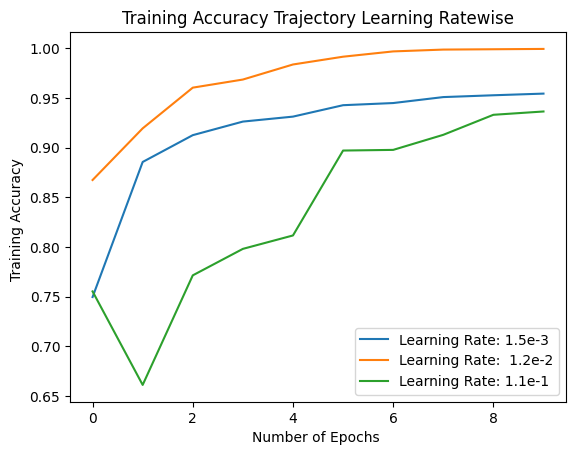

In [ ]:

plt.ylabel("Training Accuracy ")
plt.xlabel("Number of Epochs ") 
plt.plot(train_acc_df[1.5e-3], label = "Learning Rate: 1.5e-3")
plt.plot(train_acc_df[1.2e-2], label = "Learning Rate:  1.2e-2")
plt.plot(train_acc_df[1.1e-1], label = "Learning Rate: 1.1e-1")
plt.legend()
plt.title("Training Accuracy Trajectory Learning Ratewise")

plt.show()

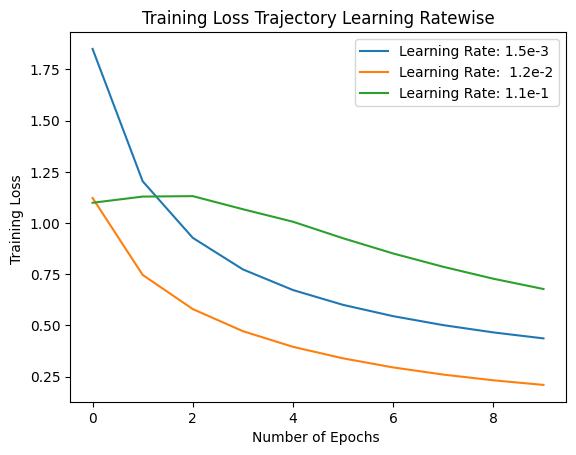

In [ ]:

plt.ylabel("Training Loss ")
plt.xlabel("Number of Epochs ") 
plt.plot(train_loss_df[1.5e-3], label = "Learning Rate: 1.5e-3")
plt.plot(train_loss_df[1.2e-2], label = "Learning Rate:  1.2e-2")
plt.plot(train_loss_df[1.1e-1], label = "Learning Rate: 1.1e-1")
plt.legend()
plt.title("Training Loss Trajectory Learning Ratewise")

plt.show()

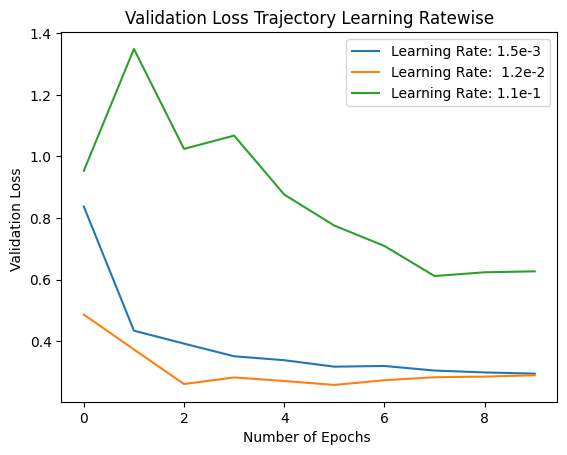

In [ ]:

plt.ylabel("Validation Loss ")
plt.xlabel("Number of Epochs ") 
plt.plot(val_loss_df[1.5e-3], label = "Learning Rate: 1.5e-3")
plt.plot(val_loss_df[1.2e-2], label = "Learning Rate:  1.2e-2")
plt.plot(val_loss_df[1.1e-1], label = "Learning Rate: 1.1e-1")
plt.legend()
plt.title("Validation Loss Trajectory Learning Ratewise")

plt.show()

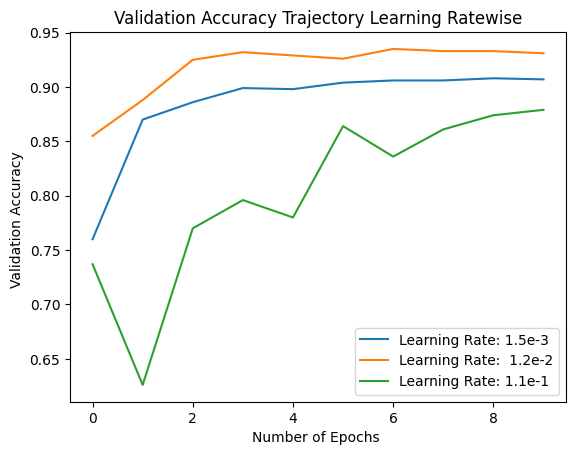

In [ ]:

plt.ylabel("Validation Accuracy ")
plt.xlabel("Number of Epochs ") 
plt.plot(val_acc_df[1.5e-3], label = "Learning Rate: 1.5e-3")
plt.plot(val_acc_df[1.2e-2], label = "Learning Rate:  1.2e-2")
plt.plot(val_acc_df[1.1e-1], label = "Learning Rate: 1.1e-1")
plt.legend()
plt.title("Validation Accuracy Trajectory Learning Ratewise")

plt.show()

Finding an optimum learning rate healps converge faster, a very high learning rate leads to divergence from the optimum point whereas a very small learning rate can take a lot of time for convergence. Also, learning rate schedules can help stabilize training. Refer: https://www.jeremyjordan.me/nn-learning-rate/

## Experiment with different Activation Functions

In [ ]:
args["train_batch_size"] = 60
args["eval_batch_size"] = 32
args["num_train_epochs"] = 5
args["optimizer"] = AdamW
args["learning_rate"] = 1.5e-3
args["adam_epsilon"] = 1e-8
args["output_dir"] = "./output/"
args["max_grad_norm"] = 1.0
args["save_steps"] = 1

In [ ]:


activationFunctions = [F.relu, F.tanh, F.sigmoid]
train_loss_df = defaultdict()
train_acc_df = defaultdict()
val_loss_df = defaultdict()
val_acc_df = defaultdict()

for bs in activationFunctions:
    args["activation"] = bs
    model = Net(args)
    model.to(args["device"])
    train_losses, train_acc, val_losses, val_acc = train(args, mnist_train, mnist_test, model)
    train_loss_df[bs] = train_losses
    train_acc_df[bs] = train_acc 
    val_loss_df[bs] = val_losses
    val_acc_df[bs] =  val_acc


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


***** Running training *****
  Num examples =  6000
  Num Epochs =  10
  Instantaneous batch size per GPU =  60


Iteration: 100%|██████████| 100/100 [00:01<00:00, 56.76it/s]


Train loss: 1.7253573632240295
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 96.40it/s]


Train accuracy: 0.772
  Num examples =  1000
  Batch size =  32



Epoch:  10%|█         | 1/10 [00:04<00:38,  4.24s/it]

Validation accuracy: 0.775
Validation loss: 0.7364944070577621
Last best epoch is 0



Iteration: 100%|██████████| 100/100 [00:02<00:00, 48.72it/s]


Train loss: 1.1289413104951382
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 142.55it/s]


Train accuracy: 0.8901666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  20%|██        | 2/10 [00:07<00:31,  3.91s/it]

Validation accuracy: 0.863
Validation loss: 0.45047700218856335
Last best epoch is 1



Iteration: 100%|██████████| 100/100 [00:01<00:00, 64.15it/s]


Train loss: 0.8740371542175611
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 136.22it/s]


Train accuracy: 0.9125
  Num examples =  1000
  Batch size =  32



Epoch:  30%|███       | 3/10 [00:11<00:25,  3.60s/it]

Validation accuracy: 0.9
Validation loss: 0.36754964967258275
Last best epoch is 2



Iteration: 100%|██████████| 100/100 [00:01<00:00, 68.32it/s]


Train loss: 0.7309590279497207
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 138.63it/s]


Train accuracy: 0.927
  Num examples =  1000
  Batch size =  32



Epoch:  40%|████      | 4/10 [00:14<00:20,  3.42s/it]

Validation accuracy: 0.905
Validation loss: 0.3437822342966683
Last best epoch is 3



Iteration: 100%|██████████| 100/100 [00:01<00:00, 59.18it/s]


Train loss: 0.636207031443715
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 100.34it/s]


Train accuracy: 0.9373333333333334
  Num examples =  1000
  Batch size =  32



Epoch:  50%|█████     | 5/10 [00:18<00:18,  3.62s/it]

Validation accuracy: 0.907
Validation loss: 0.3433381778304465
Last best epoch is 4



Iteration: 100%|██████████| 100/100 [00:02<00:00, 40.95it/s]


Train loss: 0.5679884214078387
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 132.86it/s]


Train accuracy: 0.9463333333333334
  Num examples =  1000
  Batch size =  32



Epoch:  60%|██████    | 6/10 [00:22<00:15,  3.80s/it]

Validation accuracy: 0.907
Validation loss: 0.318216850864701
Last best epoch is 5



Iteration: 100%|██████████| 100/100 [00:01<00:00, 64.84it/s]


Train loss: 0.5157413837952273
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 137.15it/s]


Train accuracy: 0.9498333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  70%|███████   | 7/10 [00:25<00:10,  3.62s/it]

Validation accuracy: 0.917
Validation loss: 0.29921313756494783
Last best epoch is 6



Iteration: 100%|██████████| 100/100 [00:01<00:00, 65.27it/s]


Train loss: 0.4742957350658253
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 129.21it/s]


Train accuracy: 0.9561666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  80%|████████  | 8/10 [00:28<00:07,  3.52s/it]

Validation accuracy: 0.905
Validation loss: 0.30210866749985144



Iteration: 100%|██████████| 100/100 [00:01<00:00, 56.02it/s]


Train loss: 0.44055284014592566
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 95.49it/s]


Train accuracy: 0.9578333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  90%|█████████ | 9/10 [00:33<00:03,  3.73s/it]

Validation accuracy: 0.908
Validation loss: 0.3007353028515354



Iteration: 100%|██████████| 100/100 [00:02<00:00, 34.70it/s]


Train loss: 0.4126250007338822
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 139.08it/s]


Train accuracy: 0.9593333333333334
  Num examples =  1000
  Batch size =  32



Epoch: 100%|██████████| 10/10 [00:37<00:00,  3.77s/it]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation accuracy: 0.911
Validation loss: 0.2939742226735689
***** Running training *****
  Num examples =  6000
  Num Epochs =  10
  Instantaneous batch size per GPU =  60


Iteration: 100%|██████████| 100/100 [00:01<00:00, 63.65it/s]


Train loss: 1.6766856688261031
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 137.46it/s]


Train accuracy: 0.8306666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  10%|█         | 1/10 [00:03<00:29,  3.23s/it]

Validation accuracy: 0.846
Validation loss: 0.8148071030154824
Last best epoch is 0



Iteration: 100%|██████████| 100/100 [00:01<00:00, 66.42it/s]


Train loss: 1.1134233689308166
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 137.39it/s]


Train accuracy: 0.904
  Num examples =  1000
  Batch size =  32



Epoch:  20%|██        | 2/10 [00:06<00:25,  3.20s/it]

Validation accuracy: 0.878
Validation loss: 0.4470774468500167
Last best epoch is 1



Iteration: 100%|██████████| 100/100 [00:01<00:00, 58.67it/s]


Train loss: 0.8611563391983509
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 103.24it/s]


Train accuracy: 0.927
  Num examples =  1000
  Batch size =  32



Epoch:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

Validation accuracy: 0.899
Validation loss: 0.37962597189471126
Last best epoch is 2



Iteration: 100%|██████████| 100/100 [00:02<00:00, 41.30it/s]


Train loss: 0.7153406070545316
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 140.27it/s]


Train accuracy: 0.9423333333333334
  Num examples =  1000
  Batch size =  32



Epoch:  40%|████      | 4/10 [00:14<00:22,  3.74s/it]

Validation accuracy: 0.906
Validation loss: 0.3406270892592147
Last best epoch is 3



Iteration: 100%|██████████| 100/100 [00:01<00:00, 64.67it/s]


Train loss: 0.6185676362067462
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 140.07it/s]


Train accuracy: 0.948
  Num examples =  1000
  Batch size =  32



Epoch:  50%|█████     | 5/10 [00:17<00:17,  3.55s/it]

Validation accuracy: 0.903
Validation loss: 0.3205613740719855



Iteration: 100%|██████████| 100/100 [00:01<00:00, 63.69it/s]


Train loss: 0.5489297692726056
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 133.50it/s]


Train accuracy: 0.9551666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  60%|██████    | 6/10 [00:20<00:13,  3.46s/it]

Validation accuracy: 0.911
Validation loss: 0.29884178459178656
Last best epoch is 5



Iteration: 100%|██████████| 100/100 [00:01<00:00, 63.72it/s]


Train loss: 0.4960827616921493
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 98.12it/s]


Train accuracy: 0.9628333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  70%|███████   | 7/10 [00:24<00:10,  3.59s/it]

Validation accuracy: 0.917
Validation loss: 0.29048416391015053
Last best epoch is 6



Iteration: 100%|██████████| 100/100 [00:02<00:00, 40.83it/s]


Train loss: 0.45432811313774435
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 121.47it/s]


Train accuracy: 0.9648333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  80%|████████  | 8/10 [00:29<00:07,  3.82s/it]

Validation accuracy: 0.911
Validation loss: 0.2866984560387209



Iteration: 100%|██████████| 100/100 [00:01<00:00, 62.49it/s]


Train loss: 0.4205136931480633
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 128.06it/s]


Train accuracy: 0.9671666666666666
  Num examples =  1000
  Batch size =  32



Epoch:  90%|█████████ | 9/10 [00:32<00:03,  3.69s/it]

Validation accuracy: 0.914
Validation loss: 0.2824936420074664



Iteration: 100%|██████████| 100/100 [00:01<00:00, 62.15it/s]


Train loss: 0.3927195698954165
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 131.60it/s]


Train accuracy: 0.9678333333333333
  Num examples =  1000
  Batch size =  32



Epoch: 100%|██████████| 10/10 [00:35<00:00,  3.58s/it]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation accuracy: 0.916
Validation loss: 0.2820410751737654
***** Running training *****
  Num examples =  6000
  Num Epochs =  10
  Instantaneous batch size per GPU =  60


Iteration: 100%|██████████| 100/100 [00:01<00:00, 62.17it/s]


Train loss: 2.2496552586555483
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 98.64it/s] 


Train accuracy: 0.617
  Num examples =  1000
  Batch size =  32



Epoch:  10%|█         | 1/10 [00:03<00:35,  3.93s/it]

Validation accuracy: 0.641
Validation loss: 2.07248018309474
Last best epoch is 0



Iteration: 100%|██████████| 100/100 [00:02<00:00, 42.49it/s]


Train loss: 1.9640307998657227
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 117.20it/s]


Train accuracy: 0.7553333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  20%|██        | 2/10 [00:08<00:33,  4.13s/it]

Validation accuracy: 0.754
Validation loss: 1.3119954019784927
Last best epoch is 1



Iteration: 100%|██████████| 100/100 [00:02<00:00, 49.91it/s]


Train loss: 1.670910919904709
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 130.65it/s]


Train accuracy: 0.8446666666666667
  Num examples =  1000
  Batch size =  32



Epoch:  30%|███       | 3/10 [00:11<00:27,  3.97s/it]

Validation accuracy: 0.832
Validation loss: 0.9118505343794823
Last best epoch is 2



Iteration: 100%|██████████| 100/100 [00:01<00:00, 62.59it/s]


Train loss: 1.447467184960842
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 132.67it/s]


Train accuracy: 0.8708333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  40%|████      | 4/10 [00:15<00:22,  3.72s/it]

Validation accuracy: 0.852
Validation loss: 0.7061687568202615
Last best epoch is 3



Iteration: 100%|██████████| 100/100 [00:01<00:00, 56.98it/s]


Train loss: 1.2804493260979652
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:02<00:00, 88.51it/s] 


Train accuracy: 0.8873333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  50%|█████     | 5/10 [00:19<00:19,  3.94s/it]

Validation accuracy: 0.861
Validation loss: 0.6018408974632621
Last best epoch is 4



Iteration: 100%|██████████| 100/100 [00:02<00:00, 39.59it/s]


Train loss: 1.1539686047534148
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 129.37it/s]


Train accuracy: 0.8998333333333334
  Num examples =  1000
  Batch size =  32



Epoch:  60%|██████    | 6/10 [00:23<00:16,  4.06s/it]

Validation accuracy: 0.875
Validation loss: 0.5445597874931991
Last best epoch is 5



Iteration: 100%|██████████| 100/100 [00:01<00:00, 63.94it/s]


Train loss: 1.0558587941953115
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 133.10it/s]


Train accuracy: 0.9033333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  70%|███████   | 7/10 [00:27<00:11,  3.81s/it]

Validation accuracy: 0.875
Validation loss: 0.5101162916980684



Iteration: 100%|██████████| 100/100 [00:01<00:00, 61.65it/s]


Train loss: 0.9780546266585588
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 123.44it/s]


Train accuracy: 0.9093333333333333
  Num examples =  1000
  Batch size =  32



Epoch:  80%|████████  | 8/10 [00:30<00:07,  3.70s/it]

Validation accuracy: 0.88
Validation loss: 0.4909582734107971
Last best epoch is 7



Iteration: 100%|██████████| 100/100 [00:01<00:00, 55.15it/s]


Train loss: 0.9152229744527075
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 97.58it/s]


Train accuracy: 0.9118333333333334
  Num examples =  1000
  Batch size =  32



Epoch:  90%|█████████ | 9/10 [00:34<00:03,  3.85s/it]

Validation accuracy: 0.882
Validation loss: 0.47832147777080536
Last best epoch is 8



Iteration: 100%|██████████| 100/100 [00:02<00:00, 39.27it/s]


Train loss: 0.8639187146723271
Train accuracy stats: 
  Num examples =  6000
  Batch size =  32



Evaluating: 100%|██████████| 188/188 [00:01<00:00, 130.15it/s]


Train accuracy: 0.9116666666666666
  Num examples =  1000
  Batch size =  32



Epoch: 100%|██████████| 10/10 [00:39<00:00,  3.92s/it]

Validation accuracy: 0.882
Validation loss: 0.4758273898623884


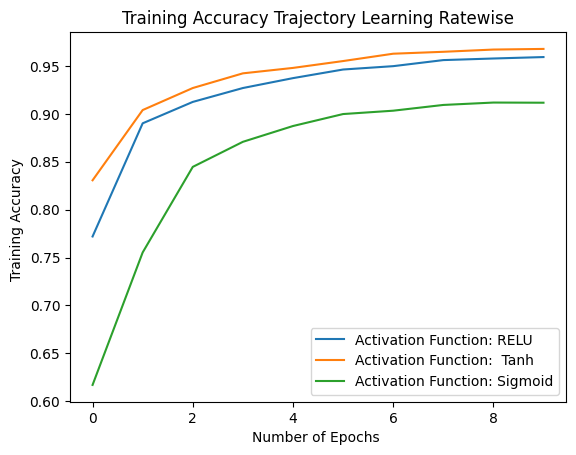

In [ ]:

plt.ylabel("Training Accuracy ")
plt.xlabel("Number of Epochs ") 
plt.plot(train_acc_df[F.relu], label = "Activation Function: RELU")
plt.plot(train_acc_df[F.tanh], label = "Activation Function:  Tanh")
plt.plot(train_acc_df[F.sigmoid], label = "Activation Function: Sigmoid")
plt.legend()
plt.title("Training Accuracy Trajectory Learning Ratewise")

plt.show()

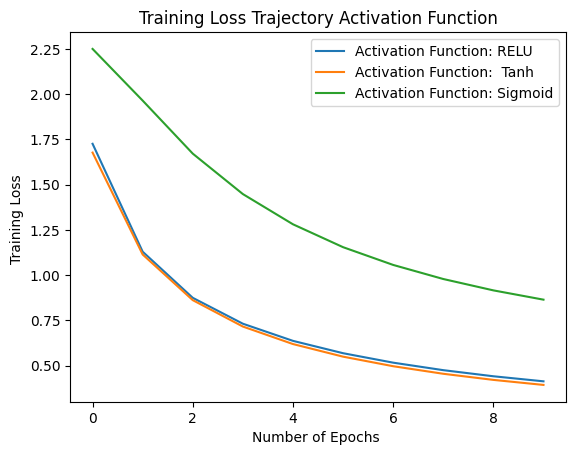

In [ ]:
plt.ylabel("Training Loss ")
plt.xlabel("Number of Epochs ") 
plt.plot(train_loss_df[F.relu], label = "Activation Function: RELU")
plt.plot(train_loss_df[F.tanh], label = "Activation Function:  Tanh")
plt.plot(train_loss_df[F.sigmoid], label = "Activation Function: Sigmoid")
plt.legend()
plt.title("Training Loss Trajectory Activation Function")

plt.show()

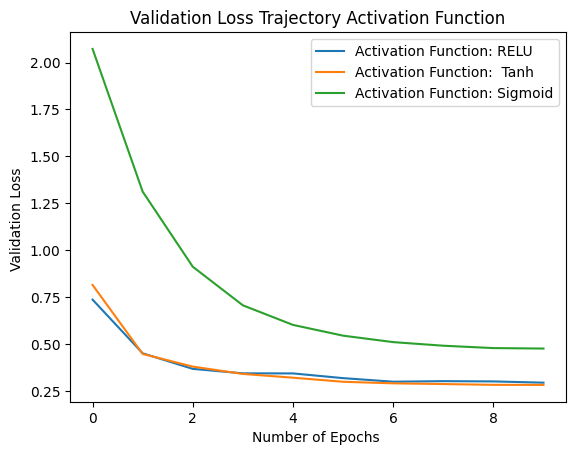

In [ ]:
plt.ylabel("Validation Loss ")
plt.xlabel("Number of Epochs ") 
plt.plot(val_loss_df[F.relu], label = "Activation Function: RELU")
plt.plot(val_loss_df[F.tanh], label = "Activation Function:  Tanh")
plt.plot(val_loss_df[F.sigmoid], label = "Activation Function: Sigmoid")
plt.legend()
plt.title("Validation Loss Trajectory Activation Function")

plt.show()

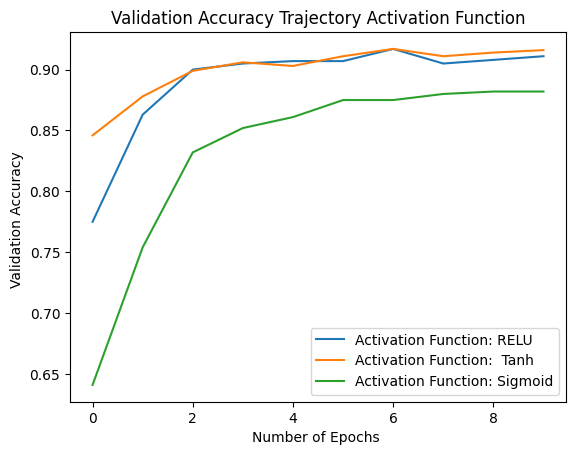

In [ ]:
plt.ylabel("Validation Accuracy ")
plt.xlabel("Number of Epochs ") 
plt.plot(val_acc_df[F.relu], label = "Activation Function: RELU")
plt.plot(val_acc_df[F.tanh], label = "Activation Function:  Tanh")
plt.plot(val_acc_df[F.sigmoid], label = "Activation Function: Sigmoid")
plt.legend()
plt.title("Validation Accuracy Trajectory Activation Function")

plt.show()

Amongst the above activation functions, Relu performs the best and sigmoid the worse possibly due to vanishing gradient problem. Refer: https://towardsdatascience.com/why-rectified-linear-unit-relu-in-deep-learning-and-the-best-practice-to-use-it-with-tensorflow-e9880933b7ef